<a href="https://colab.research.google.com/github/shaon11579/DNN-fall-2021/blob/main/Ensemble_Models_with%20titatnoc%20data%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Models

In [70]:

import sklearn
import xgboost as xgb
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [71]:

# ML Algorithms used 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC

In [14]:

import warnings
warnings.filterwarnings('ignore')

In [72]:
# Load in the train and test datasets
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [74]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [75]:
train.describe

<bound method NDFrame.describe of      PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0              1         0       3  ...   7.2500   NaN         S
1              2         1       1  ...  71.2833   C85         C
2              3         1       3  ...   7.9250   NaN         S
3              4         1       1  ...  53.1000  C123         S
4              5         0       3  ...   8.0500   NaN         S
..           ...       ...     ...  ...      ...   ...       ...
886          887         0       2  ...  13.0000   NaN         S
887          888         1       1  ...  30.0000   B42         S
888          889         0       3  ...  23.4500   NaN         S
889          890         1       1  ...  30.0000  C148         C
890          891         0       3  ...   7.7500   NaN         Q

[891 rows x 12 columns]>


# Visualizing the data properities

In [76]:
# Checking the number of rows having null values
train[train.columns[train.isnull().any()]].isnull().sum()

Age         177
Cabin       687
Embarked      2
dtype: int64

0    0.616162
1    0.383838
Name: Survived, dtype: float64


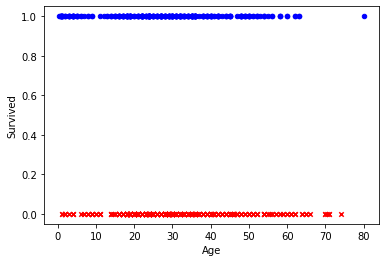

In [77]:
print(train['Survived'].value_counts()/len(train))
fig, ax = plt.subplots()
markers = ['x','o']
for i in range(2):
    if i == 0:
        color = 'red'
    else: color = 'blue'
    train[train['Survived'].eq(i)].plot.scatter(x='Age', 
                                              y='Survived', 
                                              marker=markers[i],color = color,
                                              ax=ax)

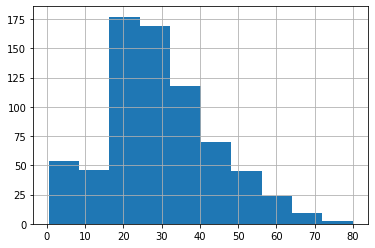

In [78]:
train['Age'].hist()

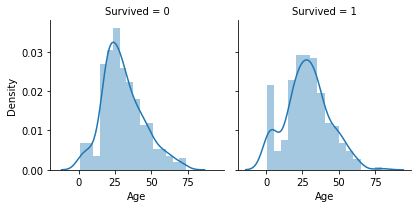

In [79]:
# Age/survived columns comparison 
graph = sns.FacetGrid(train, col='Survived')
graph.map(sns.distplot, "Age")

Text(0, 0.5, 'Probability')

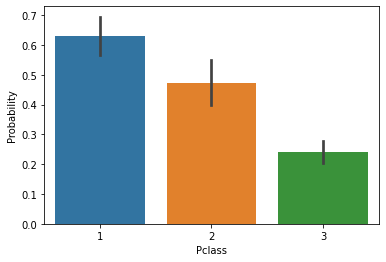

In [80]:
# Porbability of surviving based on the Pclass
graph = sns.barplot(x="Pclass",y="Survived",data=train)
graph.set_ylabel("Probability")

# Feature Exploration, Engineering and Cleaning

In [81]:

# Applying the pipline on training/testing data
full_dataset = [train, test]

In [82]:

train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [83]:
# Some features that can be created from the Name column

# Name Length
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Featurizing titles from names using Regular Expression
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_dataset:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_dataset:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [84]:
full_dataset[0].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,16,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,23,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,30,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,49,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,35,Mrs


[None, None, None, None, None, None, None, None, None, None]

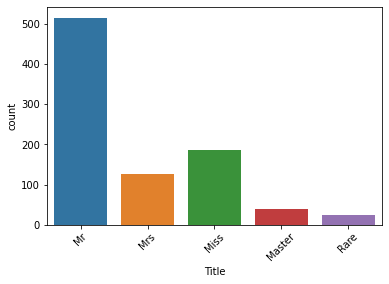

In [85]:
graph = sns.countplot(x="Title",data=full_dataset[0])
plt.setp(graph.get_xticklabels(), rotation=45)

In [86]:
# Making the column a boolean one 
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [87]:
# FamilySize can be the sum of SibSp and Parch + 1
for dataset in full_dataset:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Adding anther column for passengers travelling along
for dataset in full_dataset:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

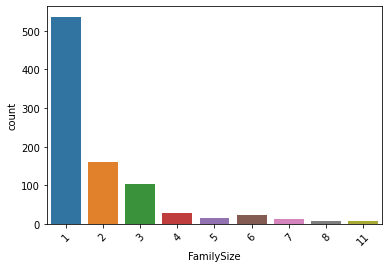

In [88]:
graph = sns.countplot(x="FamilySize",data=full_dataset[0])
plt.setp(graph.get_xticklabels(), rotation=45)

In [89]:
# We saw couple of rows have null values for some columns, let's get that fixed
# Column: Embarked
for dataset in full_dataset:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Column: Fare 
for dataset in full_dataset:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [90]:
# Column: Fare
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [91]:
# Making Age column a categorical
for dataset in full_dataset:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [92]:
# Columns: Titles, sex, embarked, Fare, Age
for dataset in full_dataset:
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
    
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int) 
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [93]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [94]:
training_cols = ['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title']

In [95]:
train.head(10)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Title,Has_Cabin,FamilySize,IsAlone
0,0,3,1,1,0,0,0,23,1,0,2,0
1,1,1,0,2,0,3,1,51,3,1,2,0
2,1,3,0,1,0,1,0,22,2,0,1,1
3,1,1,0,2,0,3,0,44,3,1,2,0
4,0,3,1,2,0,1,0,24,1,0,1,1
5,0,3,1,2,0,1,2,16,1,0,1,1
6,0,1,1,3,0,3,0,23,1,1,1,1
7,0,3,1,0,1,2,0,30,4,0,5,0
8,1,3,0,1,2,1,0,49,3,0,3,0
9,1,2,0,0,0,2,1,35,3,0,2,0


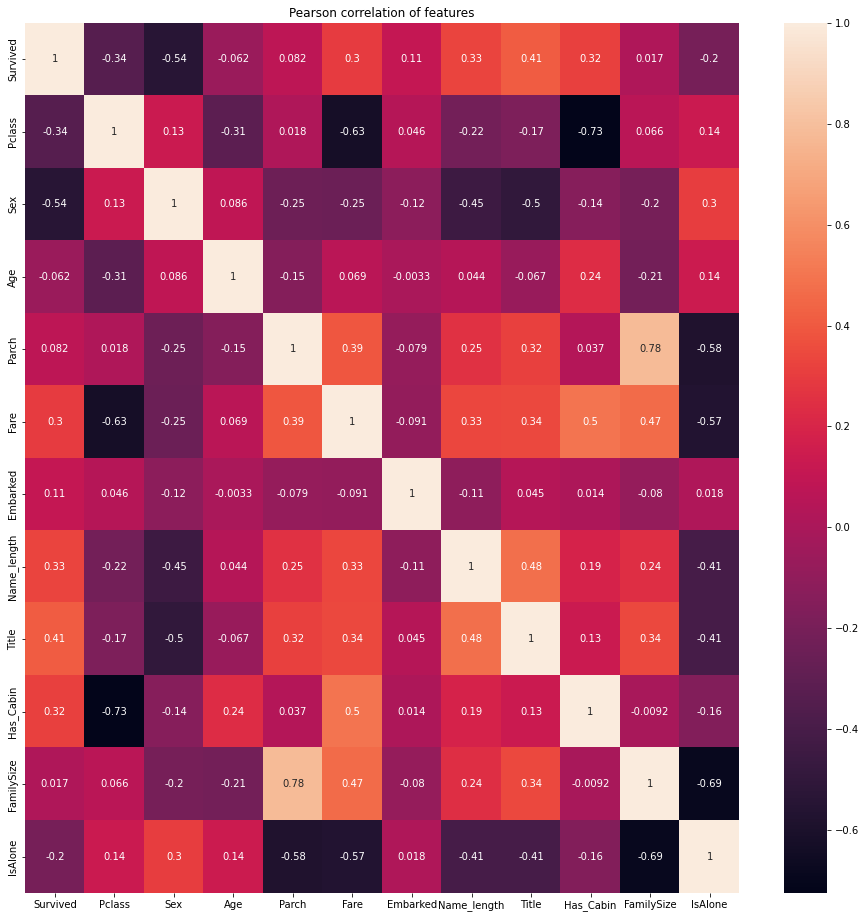

In [96]:

colormap = plt.cm.RdBu
plt.figure(figsize=(16,16))
plt.title('Pearson correlation of features')
sns.heatmap(train.astype(float).corr(), annot=True)

# Ensembling & Stacking models

In [97]:

# Model Class to be used for different ML algorithms
class ClassifierModel(object):
    def __init__(self, clf, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
    def predict(self, x):
        return self.clf.predict(x)

In [98]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [99]:
def trainModel(model, x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds, random_state=seed)
    scores = cross_val_score(model.clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(model.clf, x_train, y_train, cv=cv, n_jobs=-1)
    return scores, y_pred

# Random Forest Classifier

In [100]:

# Random Forest parameters
rf_params = {
    'n_estimators': 400,
    'max_depth': 5,
    'min_samples_leaf': 3,
    'max_features' : 'sqrt',
}
rfc_model = ClassifierModel(clf=RandomForestClassifier, params=rf_params)
rfc_scores, rfc_train_pred = trainModel(rfc_model,x_train, y_train, x_test, 5, 0) # Random Forest
rfc_scores

array([0.83240223, 0.80898876, 0.81460674, 0.79775281, 0.85393258])

In [101]:
# Getting features importance 
rfc_features = rfc_model.feature_importances(x_train,y_train)
rfc_features

array([0.1128323 , 0.26516358, 0.02308843, 0.01704889, 0.04618669,
       0.01938028, 0.08818081, 0.28594993, 0.0658896 , 0.06701471,
       0.00926479])

# Extra Trees Classifier

In [102]:
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':400,
    'max_depth': 5,
    'min_samples_leaf': 2,
}
etc_model = ClassifierModel(clf=ExtraTreesClassifier, params=et_params)
etc_scores, etc_train_pred = trainModel(etc_model,x_train, y_train, x_test, 5, 0) # Random Forest
etc_scores

array([0.83798883, 0.80337079, 0.81460674, 0.78089888, 0.84831461])

In [103]:
# Getting features importance 
etc_features = etc_model.feature_importances(x_train, y_train)
etc_features

array([0.11956004, 0.42485839, 0.01556137, 0.01119535, 0.04390816,
       0.01747609, 0.03580436, 0.17772264, 0.10211247, 0.02947866,
       0.02232248])

# AdaBoost Classifier

In [104]:
# AdaBoost parameters
ada_params = {
    'n_estimators': 400,
    'learning_rate' : 0.65
}
ada_model = ClassifierModel(clf=AdaBoostClassifier, params=ada_params)
ada_scores, ada_train_pred = trainModel(ada_model,x_train, y_train, x_test, 5, 0) # Random Forest
ada_scores

array([0.81005587, 0.78089888, 0.80898876, 0.81460674, 0.83707865])

In [105]:

# Getting features importance 
ada_features = ada_model.feature_importances(x_train, y_train)
ada_features

array([0.035 , 0.0125, 0.03  , 0.075 , 0.0375, 0.0125, 0.6275, 0.09  ,
       0.01  , 0.065 , 0.005 ])

# XGBoost Classifier

In [106]:
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 400,
    'max_depth': 6,
}
gbc_model = ClassifierModel(clf=GradientBoostingClassifier, params=gb_params)
gbc_scores, gbc_train_pred = trainModel(gbc_model,x_train, y_train, x_test, 5, 0) # Random Forest
gbc_scores

array([0.75977654, 0.79775281, 0.80337079, 0.80337079, 0.83707865])

In [107]:

# Getting features importance 
gbc_features = gbc_model.feature_importances(x_train,y_train)
gbc_features

array([0.07870377, 0.00837451, 0.05270887, 0.01698399, 0.05491988,
       0.03315282, 0.18689188, 0.40983749, 0.03566845, 0.11368432,
       0.00907402])

# Support Vector Classifier

In [108]:
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }
svc_model = ClassifierModel(clf=SVC, params=svc_params)
svc_scores, svc_train_pred = trainModel(svc_model,x_train, y_train, x_test, 5, 0) # Random Forest
svc_scores

array([0.83240223, 0.80337079, 0.82022472, 0.7752809 , 0.83707865])

# Features Importance

In [109]:

# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': train.columns.values,
    'Random Forest feature importances': rfc_features,
    'Extra Trees  feature importances': etc_features,
    'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gbc_features
    })

In [110]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.112832,0.119560,0.0350,0.078704,0.086524
1,Sex,0.265164,0.424858,0.0125,0.008375,0.177724
2,Age,0.023088,0.015561,0.0300,0.052709,0.030340
3,Parch,0.017049,0.011195,0.0750,0.016984,0.030057
4,Fare,0.046187,0.043908,0.0375,0.054920,0.045629
5,Embarked,0.019380,0.017476,0.0125,0.033153,0.020627
6,Name_length,0.088181,0.035804,0.6275,0.186892,0.234594
7,Title,0.285950,0.177723,0.0900,0.409837,0.240878
8,Has_Cabin,0.065890,0.102112,0.0100,0.035668,0.053418
9,FamilySize,0.067015,0.029479,0.0650,0.113684,0.068794


In [111]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [112]:

acc_pred_train = pd.DataFrame ({'RandomForest': rfc_scores.ravel(),
     'ExtraTrees': etc_scores.ravel(),
     'AdaBoost': ada_scores.ravel(),
      'GradientBoost': gbc_scores.ravel()
    })
acc_pred_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.832402,0.837989,0.810056,0.759777
1,0.808989,0.803371,0.780899,0.797753
2,0.814607,0.814607,0.808989,0.803371
3,0.797753,0.780899,0.814607,0.803371
4,0.853933,0.848315,0.837079,0.837079


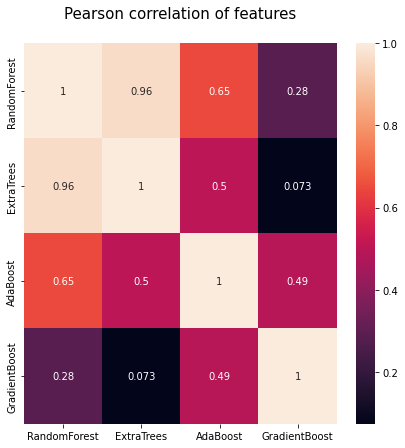

In [113]:

colormap = plt.cm.RdBu
plt.figure(figsize=(7,7))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(acc_pred_train.astype(float).corr(), annot=True)

In [114]:
x_train = np.column_stack(( etc_train_pred, rfc_train_pred, ada_train_pred, gbc_train_pred, svc_train_pred))

In [115]:
x_train.shape

(891, 5)

In [116]:
acc_pred_train

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.832402,0.837989,0.810056,0.759777
1,0.808989,0.803371,0.780899,0.797753
2,0.814607,0.814607,0.808989,0.803371
3,0.797753,0.780899,0.814607,0.803371
4,0.853933,0.848315,0.837079,0.837079


In [117]:
def trainStackModel(x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds, random_state=seed)
    gbm = xgb.XGBClassifier(
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     scale_pos_weight=1).fit(x_train, y_train)
    
    scores = cross_val_score(gbm, x_train, y_train, scoring='accuracy', cv=cv)
    return scores

In [118]:

stackModel_scores = trainStackModel(x_train, y_train, x_test, 5, 0)

In [119]:
acc_pred_train['stackingModel'] = stackModel_scores
acc_pred_train

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,stackingModel
0,0.832402,0.837989,0.810056,0.759777,0.810056
1,0.808989,0.803371,0.780899,0.797753,0.808989
2,0.814607,0.814607,0.808989,0.803371,0.837079
3,0.797753,0.780899,0.814607,0.803371,0.786517
4,0.853933,0.848315,0.837079,0.837079,0.859551


#load titatnic data from kaggle 

In [120]:
# first run this code 
!pip install -q kaggle

!pip install kaggle

In [121]:
#upload api token you have downloaded from kaaggle 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shaon11579","key":"b3304201683dc95ee8cd4d81d98dfeb7"}'}

In [123]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/content/.kaggle/kaggle.json': No such file or directory


In [63]:
!echo '{"username":"USERNAME","key":"KEY"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d mmoreaux/environmental-sound-classification-50

401 - Unauthorized


In [65]:
! touch /root/.kaggle/kaggle.json
! chmod 600 /root/.kaggle/kaggle.json
! echo '{"username":"shaon11579","key":"b3304201683dc95ee8cd4d81d98dfeb7"}' >> /root/.kaggle/kaggle.json
! kaggle competitions download -c "kaggle datasets download -d akash2sharma/tiny-imagenet"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self._load_config(config_data)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 190, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.


In [61]:
# create a dir
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [68]:
! python3 -m pip install kaggle 

In [56]:
#copy keggle.json file 

! cp kaggle.json ~/.kaggle/

In [124]:

#list data from kaggle 
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-01 17:39:01          13469  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           8086  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3572  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Women                               838MB  2021-02-28 14:56:00           1538  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [125]:
! kaggle datasets download -d akash2sharma/tiny-imagenet

100% 473M/474M [00:08<00:00, 73.9MB/s]
100% 474M/474M [00:08<00:00, 60.9MB/s]


In [126]:
! kaggle datasets download -d zaiyankhan/15scene-dataset

 94% 154M/165M [00:03<00:00, 28.6MB/s]
100% 165M/165M [00:03<00:00, 53.4MB/s]


In [141]:
tf.keras.layers.BatchNormalization(
    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones', beta_regularizer=None,
    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None, **kwargs
)

NameError: ignored

In [140]:
import tensorflow as tf
import keras
import keras.utils
import sklearn
from sklearn.model_selection import cross_validate
import sklearn.metrics
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras import utils as np_utils
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, MaxPool2D, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
!pip install BatchNormalization

ImportError: ignored

In [144]:
!unzip /content/15scene-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: 15-Scene/13/3971.jpg    
  inflating: 15-Scene/13/3972.jpg    
  inflating: 15-Scene/13/3973.jpg    
  inflating: 15-Scene/13/3974.jpg    
  inflating: 15-Scene/13/3975.jpg    
  inflating: 15-Scene/13/3976.jpg    
  inflating: 15-Scene/13/3977.jpg    
  inflating: 15-Scene/13/3978.jpg    
  inflating: 15-Scene/13/3979.jpg    
  inflating: 15-Scene/13/3980.jpg    
  inflating: 15-Scene/13/3981.jpg    
  inflating: 15-Scene/13/3982.jpg    
  inflating: 15-Scene/13/3983.jpg    
  inflating: 15-Scene/13/3984.jpg    
  inflating: 15-Scene/13/3985.jpg    
  inflating: 15-Scene/13/3986.jpg    
  inflating: 15-Scene/13/3987.jpg    
  inflating: 15-Scene/13/3988.jpg    
  inflating: 15-Scene/13/3989.jpg    
  inflating: 15-Scene/13/3990.jpg    
  inflating: 15-Scene/13/3991.jpg    
  inflating: 15-Scene/13/3992.jpg    
  inflating: 15-Scene/13/3993.jpg    
  inflating: 15-Scene/13/3994.jpg    
  inflating: 15-Scene/13/3995.jpg    

# Load the ResNet50 model...

In [151]:
!wget https://upload.wikimedia.org/wikipedia/commons/f/f9/Zoorashia_elephant.jpg -O elephant.jpg

--2021-10-11 00:47:17--  https://upload.wikimedia.org/wikipedia/commons/f/f9/Zoorashia_elephant.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168370 (164K) [image/jpeg]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>] 164.42K   726KB/s    in 0.2s    

2021-10-11 00:47:18 (726 KB/s) - ‘elephant.jpg’ saved [168370/168370]



In [152]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = 'elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n02504013', 'Indian_elephant', 0.8198577), ('n02504458', 'African_elephant', 0.11778774), ('n01871265', 'tusker', 0.058297653)]


# Extract features with VGG16

In [153]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

#base_model = VGG19(weights='imagenet', include_top=False)

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)
print('The shape of the feature representation is : ', features.shape)

58900480/58889256 [==============================] - 1s 0us/step
The shape of the feature representation is :  (1, 7, 7, 512)


# Extract features from an arbitrary intermediate layer with VGG19

In [154]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

block4_pool_features = model.predict(x)

print('The shape of the feature representation is : ', block4_pool_features.shape)

574726144/574710816 [==============================] - 10s 0us/step
The shape of the feature representation is :  (1, 14, 14, 512)


# Fine-tune InceptionV3 on a new set of classes

In [162]:
import tensorflow.keras as keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


# train the model on the new data for a few epochs
model.fit(...)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(...)


ValueError: ignored

In [163]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(224, 224, 3))

model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)

96124928/96112376 [==============================] - 2s 0us/step


# Lecture_10_TL_1

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.wrappers.scikit_learn import KerasClassifier
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout
from keras import optimizers

from tensorflow.keras.applications import VGG16

image_size = 224
#Load the VGG model

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3))

58900480/58889256 [==============================] - 1s 0us/step


In [3]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Freeze the required layers

In [4]:

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f13344d0c10> False
<keras.layers.convolutional.Conv2D object at 0x7f12d5e78e90> False
<keras.layers.convolutional.Conv2D object at 0x7f12d5ea3a90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f12d55c0d50> False
<keras.layers.convolutional.Conv2D object at 0x7f12c0111590> False
<keras.layers.convolutional.Conv2D object at 0x7f12c01181d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f12c0111190> False
<keras.layers.convolutional.Conv2D object at 0x7f12c0120d10> False
<keras.layers.convolutional.Conv2D object at 0x7f12c012a3d0> False
<keras.layers.convolutional.Conv2D object at 0x7f12c012ae10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f12c0120750> False
<keras.layers.convolutional.Conv2D object at 0x7f12c01385d0> False
<keras.layers.convolutional.Conv2D object at 0x7f12c013f2d0> False
<keras.layers.convolutional.Conv2D object at 0x7f12c0138790> False
<keras.layers.pooling.MaxPooling2D object at 0x7f12c00c9710>

# Create model

In [5]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 32,773,635
Non-trainable params: 7,635,264
_________________________________________________________________


# Load data

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 80
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

NameError: ignored

In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# Save the model
model.save('small_last4.h5')

AttributeError: ignored

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: ignored

# question 2 

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.wrappers.scikit_learn import KerasClassifier
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout
from keras import optimizers



from tensorflow.keras.applications import ResNet50

image_size = 224
#Load the VGG model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

94781440/94765736 [==============================] - 0s 0us/step


In [5]:

# Freeze the layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in resnet.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f7033308990> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7032940f10> False
<keras.layers.convolutional.Conv2D object at 0x7f70320fa490> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f70320fa5d0> False
<keras.layers.core.Activation object at 0x7f70320eee90> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f70320ee0d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7020123310> False
<keras.layers.convolutional.Conv2D object at 0x7f7020136250> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f702013b850> False
<keras.layers.core.Activation object at 0x7f7020143150> False
<keras.layers.convolutional.Conv2D object at 0x7f70200cce90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f70200cc990> False
<keras.layers.core.Activation object at 0x7f702013bc90> False
<keras.layers.convolutional.Conv

#Create model

In [7]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(resnet)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               205000    
Total params: 126,554,184
Trainable params: 104,021,192
Non-trainable params: 22,532,992
_________________________________________________________________


# Load data

In [8]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

NameError: ignored